# MNIST with Simple GANs
In this notebook, we use the GANs network train with MNIST dataset. So that the neural network could generate the hand writting digits.

#### Import packagees

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
torch.manual_seed(111)

#### Set the GPU

In [2]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#### Dataset
We load the data from `torchvision.datasets.MNIST`, and transform it to tensor with normalization. Then we save it to the loader

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
train_set = torchvision.datasets.MNIST(
    root="./", train=True, transform=transform
)
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

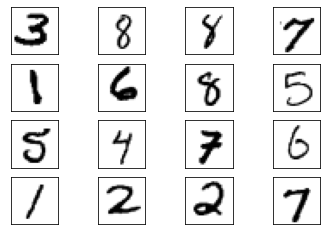

In [4]:
# Some example of MNIST
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

#### Build the NN

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [7]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

#### Set hyperparameter and Optimizer

In [8]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

g_loss = []
d_loss = []

#### Training the dataset

In [9]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()
        g_loss.append(loss_generator)
        d_loss.append(loss_discriminator)
        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5030106902122498
Epoch: 0 Loss G.: 0.6107589602470398
Epoch: 1 Loss D.: 0.008606741204857826
Epoch: 1 Loss G.: 6.080506324768066
Epoch: 2 Loss D.: 0.022986412048339844
Epoch: 2 Loss G.: 4.6529388427734375
Epoch: 3 Loss D.: 0.07607145607471466
Epoch: 3 Loss G.: 3.6938042640686035
Epoch: 4 Loss D.: 0.03457992523908615
Epoch: 4 Loss G.: 6.581266403198242
Epoch: 5 Loss D.: 0.18313492834568024
Epoch: 5 Loss G.: 3.586435556411743
Epoch: 6 Loss D.: 0.11523684859275818
Epoch: 6 Loss G.: 2.864250659942627
Epoch: 7 Loss D.: 0.2675701379776001
Epoch: 7 Loss G.: 2.8456010818481445
Epoch: 8 Loss D.: 0.21483537554740906
Epoch: 8 Loss G.: 2.78266978263855
Epoch: 9 Loss D.: 0.10982585698366165
Epoch: 9 Loss G.: 2.3742518424987793
Epoch: 10 Loss D.: 0.4044789671897888
Epoch: 10 Loss G.: 1.8116440773010254
Epoch: 11 Loss D.: 0.3166126310825348
Epoch: 11 Loss G.: 1.8744099140167236
Epoch: 12 Loss D.: 0.3198338747024536
Epoch: 12 Loss G.: 1.9465135335922241
Epoch: 13 Loss D.: 0.4611287

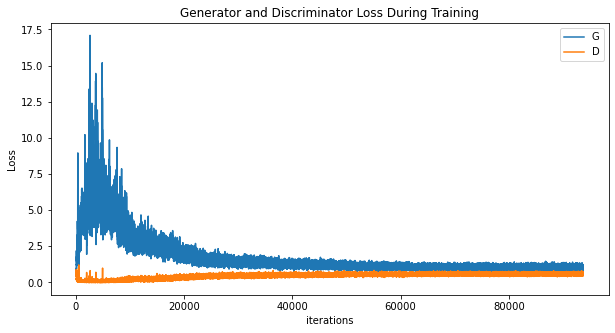

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss,label="G")
plt.plot(d_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Prediction

We generate a series of random points and let generator handle these points to transform them into hand written digits

In [12]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

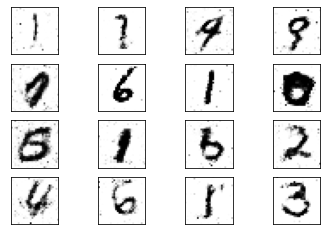

In [13]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

#### Save/Load Model

In [14]:
# Save Model
torch.save(generator, "saved_model/generator.pth")
torch.save(discriminator, "saved_model/discriminator.pth")

In [16]:
# Load Model
generator = torch.load("saved_model/generator.pth")
discriminator = torch.load("saved_model/discriminator.pth")